<a href="https://colab.research.google.com/github/Papaxristos/Cardio-disease-prediction/blob/main/Cardio-disease-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


# Controlled import for the environment
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

def load_csv():
    if IN_COLAB:
        # For Colab
        print("Please upload the CSV file.")
        uploaded = files.upload()
        for file_name in uploaded.keys():
            return pd.read_csv(file_name)
    else:
        # For Desktop Python (e.g., VS Code)
        file_path = input("Please enter the full path of the CSV file: ")
        if os.path.exists(file_path):
            return pd.read_csv(file_path)
        else:
            print("The file was not found. Please check the path.")
            return None

# Load data
data = load_csv()

if data is not None:
    print("The file was loaded successfully!")
    print(f"First 5 rows:\n{data.head()}")
else:
    print("Failed to load the file.")


Παρακαλώ ανεβάστε το αρχείο CSV.


Saving heart.csv to heart.csv
Το αρχείο φορτώθηκε επιτυχώς!
Πρώτες 5 γραμμές:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  



Στατιστικά Περιγραφικά:
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000   

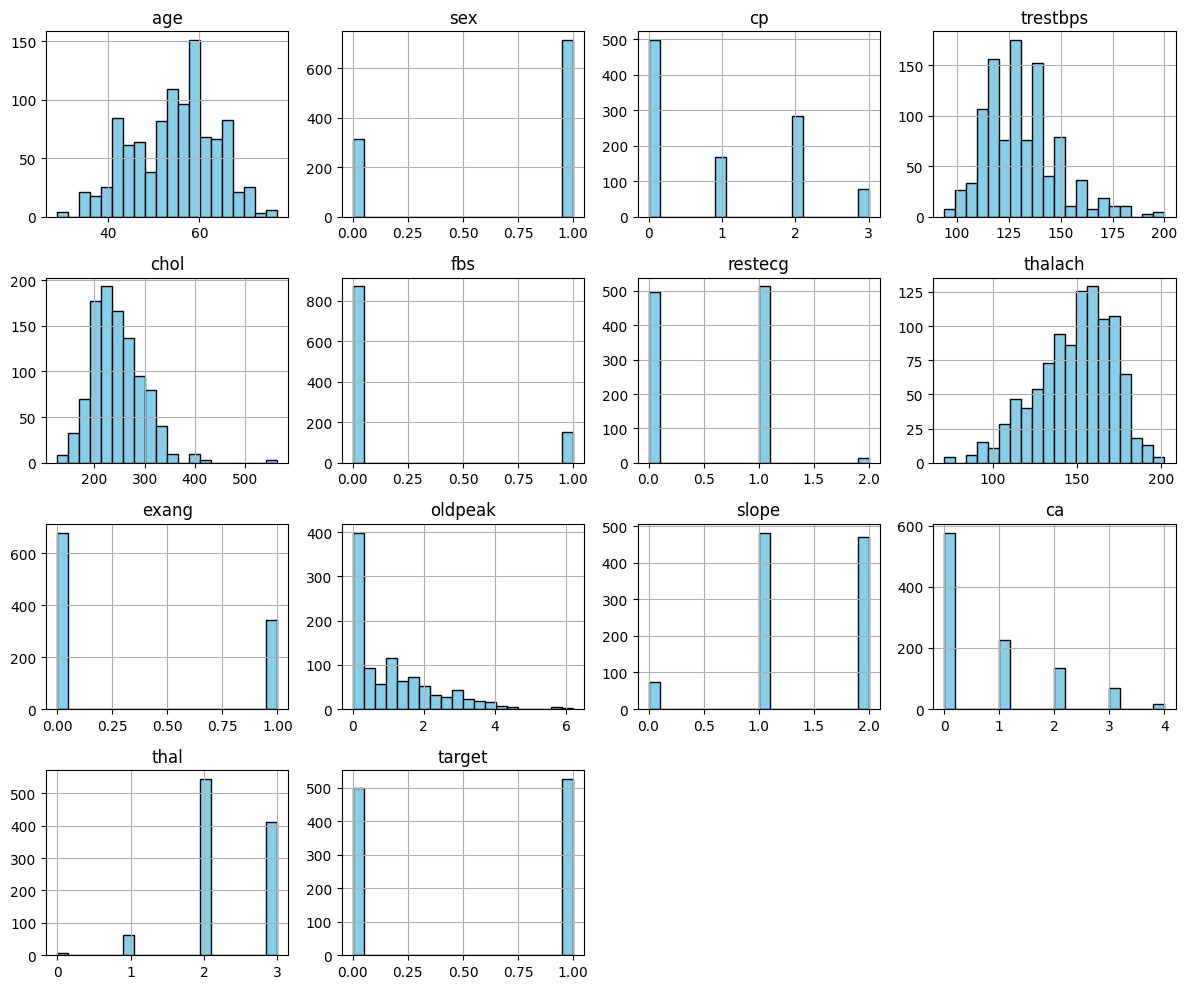


Boxplots για όλα τα χαρακτηριστικά:


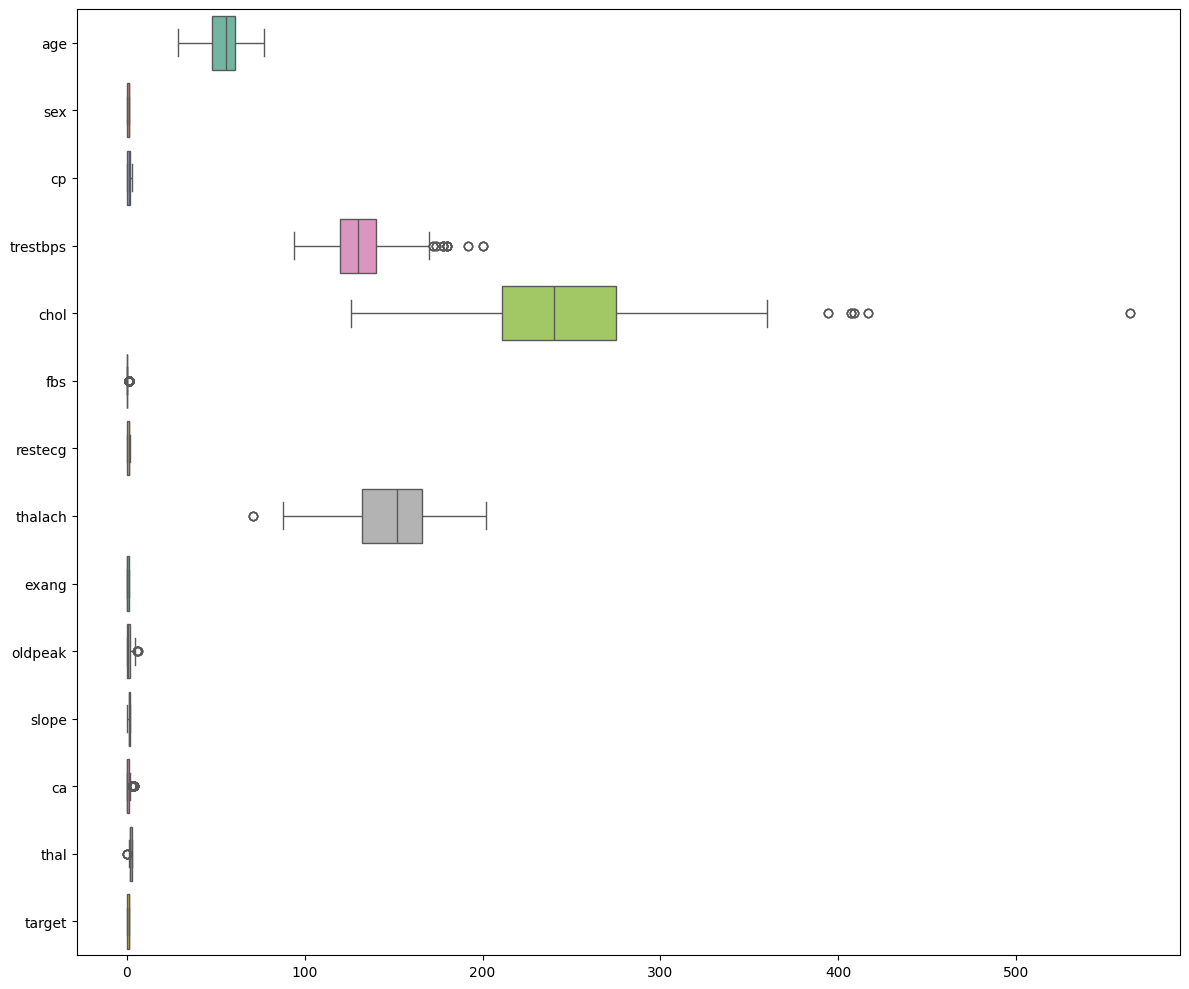


Heatmap Συσχετίσεων:


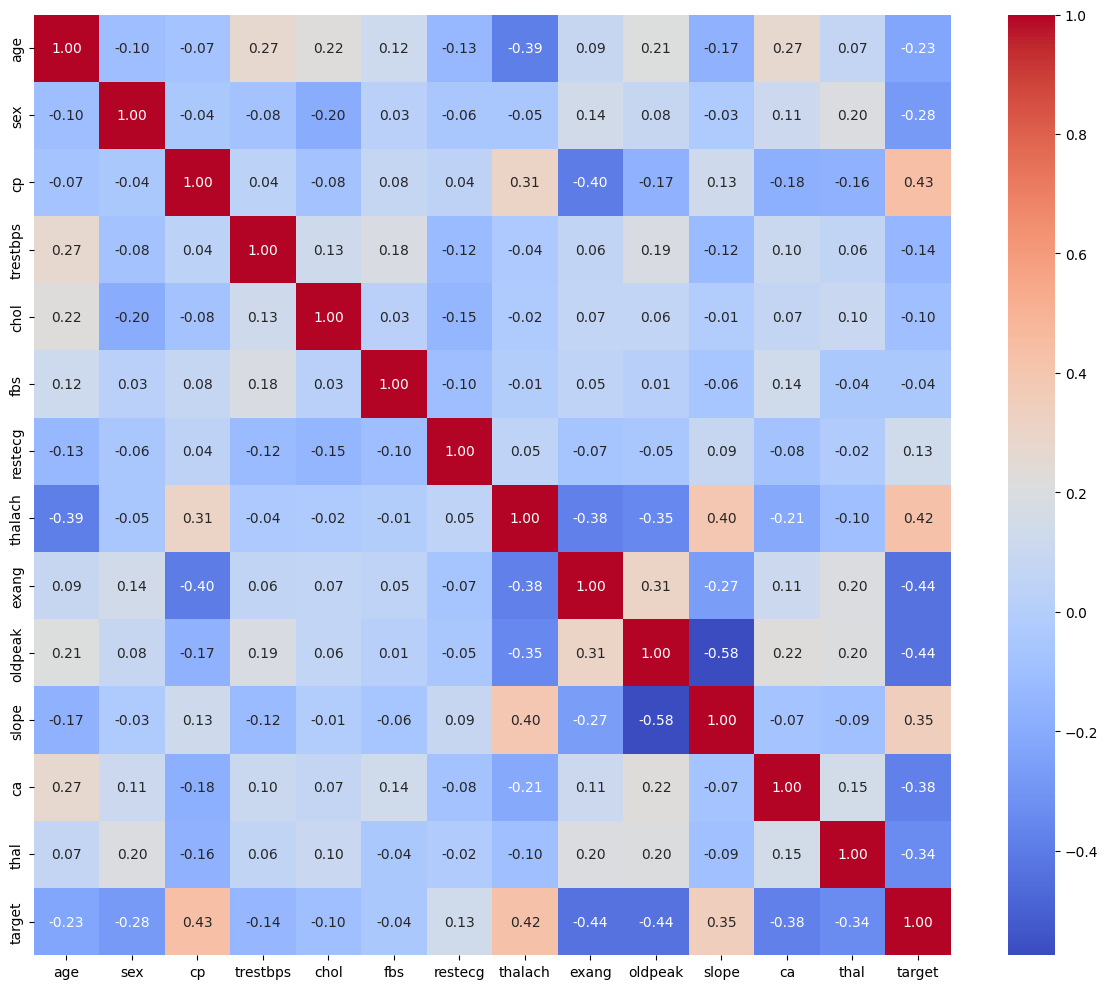

In [ ]:
# Function for descriptive statistics
def descriptive_statistics(data):
    print("\nDescriptive Statistics:")
    print(data.describe())

# Function for checking missing data
def missing_data(data):
    print("\nMissing Data:")
    print(data.isnull().sum())

# Function for visualizing histograms
def plot_histograms(data):
    print("\nHistograms for all features:")
    data.hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
    plt.tight_layout()
    plt.show()

# Function for visualizing boxplots
def plot_boxplots(data):
    print("\nBoxplots for all features:")
    plt.figure(figsize=(12, 10))
    sns.boxplot(data=data, orient="h", palette="Set2")
    plt.tight_layout()
    plt.show()

# Function for visualizing correlation heatmap
def plot_heatmap(data):
    print("\nCorrelation Heatmap:")
    numeric_data = data.select_dtypes(include=[np.number])
    if numeric_data.empty:
        print("No numeric data available for correlation calculation.")
        return
    correlation_matrix = numeric_data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.tight_layout()
    plt.show()

# Perform Exploratory Data Analysis (EDA)
descriptive_statistics(data)
missing_data(data)
plot_histograms(data)
plot_boxplots(data)
plot_heatmap(data)


In [ ]:
# Check if we are running in Google Colab or not
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

# Remove outliers for all numeric columns
def remove_outliers(data):
    # Find numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    # Define outlier thresholds (99th percentile)
    for col in numeric_cols:
        threshold = data[col].quantile(0.99)
        data = data[data[col] <= threshold]

    return data

# Ask the user where to save the new file (for VSCode)
def get_save_path_vscode():
    from tkinter import filedialog
    from tkinter import Tk

    root = Tk()
    root.withdraw()  # Avoid showing the Tkinter window
    save_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
    return save_path

# Save the file in Google Colab
def save_to_colab(data, filename):
    from google.colab import files
    data.to_csv(filename, index=False)
    files.download(filename)

# Apply data processing
def process_data(data):
    # Remove the 'id' column if it exists
    if 'id' in data.columns:
        data = data.drop(columns=['id'])

    # Remove outliers
    data = remove_outliers(data)

    # Select only the features to be used for training
    selected_columns = ['age', 'trestbps', 'chol', 'thalach', 'cp', 'exang', 'slope']

    # Ensure all selected columns exist in the data
    data = data[selected_columns + ['target']]  # Include the target as well

    # Convert categorical data (cp, exang, slope)
    data = pd.get_dummies(data, columns=['cp', 'exang', 'slope'], drop_first=True)

    # Replace NaN values with the mean of each column
    imputer = SimpleImputer(strategy='mean')
    data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

    return data_imputed

# Check if the 'data' variable exists from the previous cell
if 'data' in locals():
    # Display the first rows of the data
    print("First rows of the data:")
    print(data.head())

    # Process the data
    cleaned_data = process_data(data)

    # Ask the user where to save the new file
    if is_colab:
        # In Colab, save the file and download it
        save_to_colab(cleaned_data, "cleaned_data.csv")
    else:
        # In VSCode, ask the user to choose the folder and file name
        save_path = get_save_path_vscode()

        if save_path:  # If the user has selected a save location
            # Save the cleaned data to the new file
            cleaned_data.to_csv(save_path, index=False)

            # Inform the user that the file has been saved
            print(f"The cleaned data has been saved to the file: {save_path}")
        else:
            print("No folder or file selected for saving.")
else:
    print("The 'data' variable does not exist. Please ensure the data is loaded beforehand.")


Πρώτες σειρές δεδομένων:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving cleaned_data.csv to cleaned_data (3).csv
Ακρίβεια στο Test Set: 0.9950

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        98
         1.0       0.99      1.00      1.00       104

    accuracy                           1.00       202
   macro avg       1.00      0.99      1.00       202
weighted avg       1.00      1.00      1.00       202


ROC AUC: 1.0000


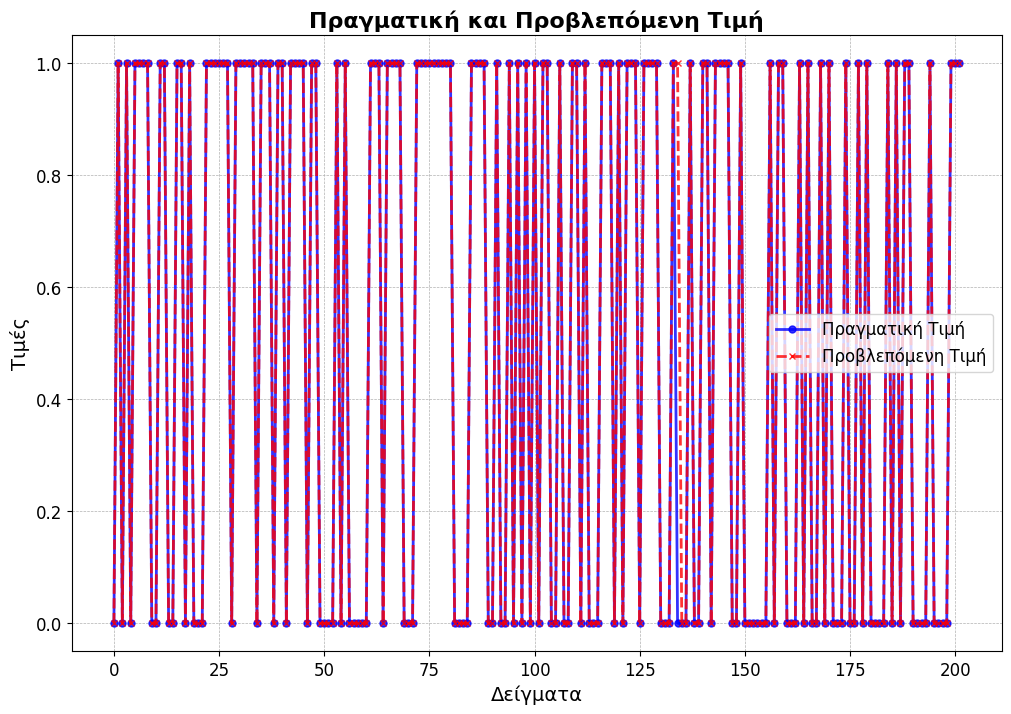

In [ ]:
# Check if we are running in Google Colab or not
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

# Function for loading the file in Google Colab or VSCode
def load_data():
    if is_colab:
        from google.colab import files
        uploaded = files.upload()
        for filename in uploaded.keys():
            data = pd.read_csv(filename)
            return data
    else:
        # In local environment (VSCode)
        from tkinter import filedialog
        from tkinter import Tk
        root = Tk()
        root.withdraw()  # Prevent the Tkinter window from showing up
        file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        data = pd.read_csv(file_path)
        return data

# Load the data
data = load_data()

# Check if the data has been loaded correctly
if data is None or data.empty:
    raise ValueError("Data was not loaded correctly.")

# Separate features and target
X = data.drop(columns=['target'])  # Here, we use the 'target' column as the target
y = data['target']

# Data balancing with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

# Calculate other metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC
if len(np.unique(y_test)) == 2:
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
else:
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled), multi_class='ovr')

print(f"\nROC AUC: {roc_auc:.4f}")

# Plotting the actual and predicted values
plt.figure(figsize=(12, 8))  # Larger image size for better distinction

# Plot the actual and predicted values with different styles
plt.plot(y_test.values, label='Actual Value', color='blue', lw=2, linestyle='-', marker='o', markersize=5, alpha=0.8)
plt.plot(y_pred, label='Predicted Value', color='red', lw=2, linestyle='--', marker='x', markersize=5, alpha=0.8)

# Add title and labels
plt.title("Actual and Predicted Value", fontsize=16, fontweight='bold')
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Values", fontsize=14)

# Add grid for better visualization
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display axis scale
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [ ]:
import joblib
from google.colab import files
import os

# Save the trained model to a file 'model.pkl' in /content (or another folder in Colab)
model_path = '/content/model.pkl'
joblib.dump(model, model_path)

# Download the file to the user's computer
files.download(model_path)

print(f"The model was successfully saved and downloaded from '{model_path}'.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Το μοντέλο αποθηκεύτηκε και κατέβηκε με επιτυχία από το '/content/model.pkl'.
